# Sentiment Analysis

## Loading Data & Descriptive Analysis

In [0]:
import numpy as np
import pandas as pd

In [0]:
train_df = pd.read_csv("/content/review_train.csv")

In [0]:
test_df = pd.read_csv("/content/review_test.csv")

In [7]:
train_df.columns.difference(test_df.columns)

Index([], dtype='object')

In [8]:
train_df.shape

(14825, 3)

In [9]:
test_df.shape

(3707, 3)

In [0]:
train_df["Source"] = "train"
test_df["Source"] = "test"

In [11]:
train_df.columns

Index(['Text', 'Score', 'Sentiment', 'Source'], dtype='object')

In [12]:
test_df.columns

Index(['Text', 'Score', 'Sentiment', 'Source'], dtype='object')

In [0]:
df = pd.concat([train_df, test_df])

In [14]:
df.shape

(18532, 4)

In [15]:
df.head()

,Text,Score,Sentiment,Source
0,"I got a free sample of these once, and now--we...",5,1,train
1,I used to get this Tea when I lived in Washing...,4,1,train
2,This is my all time favorite 'grab and go' sna...,5,1,train
3,This flavor is very good and unexpected. The ...,4,1,train
4,thrilled to have this assortment as i got the ...,4,1,train


In [16]:
df.tail()

,Text,Score,Sentiment,Source
3702,I always have Powerade in the house - for ever...,5,1,test
3703,I tried this coffee on a half dozen quests thi...,5,1,test
3704,The Neccos were exactly what I expected and fr...,5,1,test
3705,I thought I was doing the right thing by getti...,1,0,test
3706,Cugino's chicken noodle soup is pretty tasty. ...,5,1,test


In [17]:
df.describe()

,Score,Sentiment
count,18532.000000,18532.000000
mean,4.277304,0.843784
std,1.319827,0.363070
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


## EDA

In [18]:
df.Score.value_counts()

5    12795
4     2842
1     1866
2     1029
Name: Score, dtype: int64

In [19]:
df.Sentiment.value_counts()

1    15637
0     2895
Name: Sentiment, dtype: int64

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Score,18532.0,4.277304,1.319827,1.0,4.0,5.0,5.0,5.0
Sentiment,18532.0,0.843784,0.363070,0.0,1.0,1.0,1.0,1.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18532 entries, 0 to 3706
Data columns (total 4 columns):
Text         18532 non-null object
Score        18532 non-null int64
Sentiment    18532 non-null int64
Source       18532 non-null object
dtypes: int64(2), object(2)
memory usage: 723.9+ KB


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import seaborn as sns

Text(0.5, 1.0, 'Scores Distribution')

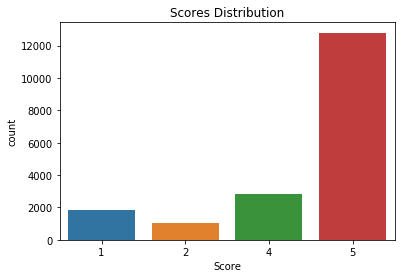

In [24]:
sns.countplot(x='Score', data=df)
plt.title("Scores Distribution")
# sns.barplot(x = df.Score.value_counts().index, y = df.Score.value_counts())

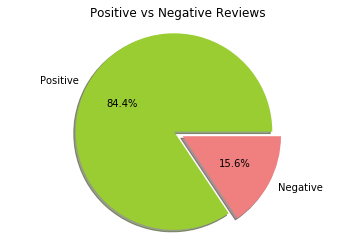

In [25]:
labels = 'Positive', 'Negative'
sizes = df.Sentiment.value_counts()
colors = ['yellowgreen', 'lightcoral']
explode = (0, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=0)
plt.title("Positive vs Negative Reviews")

plt.axis('equal')
plt.show()

In [26]:
corr = df.corr()
print(corr)

              Score  Sentiment
Score      1.000000   0.952582
Sentiment  0.952582   1.000000


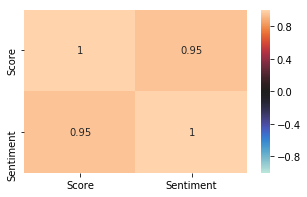

In [27]:
plt.figure(figsize=(5,3))
ax = sns.heatmap(corr,vmin=-1,vmax=1,center=0,annot=True)

## Data Preprocessing

In [28]:
df.isna().sum()

Text         0
Score        0
Sentiment    0
Source       0
dtype: int64

In [29]:
df.duplicated().sum()

433

In [0]:
# reviews = np.array(df['Text'])
# sentiments = np.array(df['Sentiment'])

In [31]:
df.columns

Index(['Text', 'Score', 'Sentiment', 'Source'], dtype='object')

In [32]:
# Removing 'Score' column as it is not needed

df.drop(columns=['Score'], inplace=True)
df.columns

Index(['Text', 'Sentiment', 'Source'], dtype='object')

In [0]:
train_final = df[df.Source=="train"]
test_final = df[df.Source=="test"]

In [0]:
train_reviews = train_final['Text'].values
train_sentiments = train_final['Sentiment'].values

test_reviews = test_final['Text'].values
test_sentiments = test_final['Sentiment'].values

### Text Preprocessor (No need to do Stop word removal for Sentiment Analysis)

In [35]:
!pip install textsearch
!pip install contractions
!pip install tqdm

     |████████████████████████████████| 317kB 6.9MB/s 
     |████████████████████████████████| 245kB 46.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81699 sha256=70521fc9469b0ce15400d15e4139c095dfd214315890f7047eb96f44ac12d026
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [36]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
!pip install spacy
import spacy

In [38]:
!python -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.1.8) ======================
ℹ spaCy installation: /usr/local/lib/python3.6/dist-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   en-core-web-sm   en_core_web_sm   2.1.0   ✔
link      en               en_core_web_sm   2.1.0   ✔



In [39]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
import re
from bs4 import BeautifulSoup
import unicodedata
import contractions
import spacy

nlp = spacy.load('en')
ps = nltk.porter.PorterStemmer()


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text):
    return contractions.fix(text)


def spacy_lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def simple_stemming(text, stemmer=ps):
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text


def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [0]:
import tqdm

def text_pre_processor(text, html_strip=True, accented_char_removal=True, contraction_expansion=True,
                       text_lower_case=True, text_stemming=False, text_lemmatization=True, 
                       special_char_removal=True, remove_digits=True, stopword_removal=False, 
                       stopword_list=None):
    
    # strip HTML
    if html_strip:
        text = strip_html_tags(text)
    
    # remove extra newlines (often might be present in really noisy text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    
    # remove accented characters
    if accented_char_removal:
        text = remove_accented_chars(text)
    
    # expand contractions    
    if contraction_expansion:
        text = expand_contractions(text)
        
#     # expand contractions without Contraction library (Custom Code)
#     if contraction_expansion:
#         text = expandContractions(text)
    
    # lemmatize text
    if text_lemmatization:
        text = spacy_lemmatize_text(text) 
        
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        text = special_char_pattern.sub(" \\1 ", text)
        text = remove_special_characters(text, remove_digits=remove_digits)  
        
    # stem text
    if text_stemming and not text_lemmatization:
        text = simple_stemming(text)
        
    # lowercase the text    
    if text_lower_case:
        text = text.lower()
        
        
    # remove stopwords
    if stopword_removal:
        text = remove_stopwords(text, is_lower_case=text_lower_case, 
                                stopwords=stopword_list)
        
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
    text = text.strip()
    
    return text

In [0]:
def pre_process(reviews):
  norm_reviews = []
  for review in tqdm.tqdm(reviews):
    review = text_pre_processor(review)  #Stop word removal is already set to False, as we are doing Sentiment Analysis
    norm_reviews.append(review)
  return norm_reviews

### Creating Normalised Data using Text Preprocessor


In [43]:
%%time

norm_train_reviews = pre_process(train_reviews)
norm_test_reviews = pre_process(test_reviews)

100%|██████████| 3707/3707 [01:22<00:00, 45.03it/s]

CPU times: user 6min 44s, sys: 4.09 s, total: 6min 48s
Wall time: 6min 47s


In [44]:
[review[0:100] for review in train_reviews[0:5]]

["I got a free sample of these once, and now--we're on the subscribe and save program.  Not much of a ",
 'I used to get this Tea when I lived in Washington State and missed it.  A niece told me it was avail',
 "This is my all time favorite 'grab and go' snack bar. It doesn't leave you with a sugar rush/drop, t",
 'This flavor is very good and unexpected.  The flavor of the cheese and garlic go well together and t',
 'thrilled to have this assortment as i got the chance to choose another decaf coffee- have already sa']

In [45]:
[review[0:100] for review in norm_train_reviews[0:5]]

['i get a free sample of these once and now we be on the subscribe and save program not much of a chip',
 'i use to get this tea when i live in washington state and miss it a niece tell me it be available at',
 'this be my all time favorite grab and go snack bar it do not leave you with a sugar rush drop taste ',
 'this flavor be very good and unexpected the flavor of the cheese and garlic go well together and the',
 'thrill to have this assortment as i get the chance to choose another decaf coffee have already sampl']

## Feature Engineering

In [46]:
%%time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=5, max_df=1.0, ngram_range=(1,2))

cv_train_features = cv.fit_transform(norm_train_reviews)


# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(norm_train_reviews)

CPU times: user 6.3 s, sys: 279 ms, total: 6.58 s
Wall time: 6.62 s


In [47]:
%%time

# transform test reviews into features
cv_test_features = cv.transform(norm_test_reviews)
tv_test_features = tv.transform(norm_test_reviews)

CPU times: user 953 ms, sys: 4.96 ms, total: 958 ms
Wall time: 960 ms


In [48]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (14825, 35004)  Test features shape: (3707, 35004)
TFIDF model:> Train features shape: (14825, 35004)  Test features shape: (3707, 35004)


## Modeling, Prediction and Performance Evaluation

### Using Logistic Regression

In [49]:
%%time

# Logistic Regression model on BOW features
from sklearn.linear_model import LogisticRegression

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# train model
lr.fit(cv_train_features, train_sentiments)

# predict on test data
lr_bow_predictions = lr.predict(cv_test_features)

CPU times: user 5.89 s, sys: 4.11 s, total: 10 s
Wall time: 5.1 s


In [50]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, lr_bow_predictions))
pd.DataFrame(confusion_matrix(test_sentiments, lr_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.83      0.69      0.76       592
           1       0.94      0.97      0.96      3115

    accuracy                           0.93      3707
   macro avg       0.89      0.83      0.86      3707
weighted avg       0.93      0.93      0.93      3707



,negative,positive
negative,410,182
positive,83,3032


### Using Random Forest

In [51]:
%%time

# Random Forest model on BOW features
from sklearn.ensemble import RandomForestClassifier

# instantiate model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# train model
rf.fit(cv_train_features, train_sentiments)

# predict on test data
rf_bow_predictions = rf.predict(cv_test_features)

CPU times: user 26 s, sys: 96.5 ms, total: 26.1 s
Wall time: 13.4 s


In [52]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, rf_bow_predictions))
pd.DataFrame(confusion_matrix(test_sentiments, rf_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.98      0.20      0.34       592
           1       0.87      1.00      0.93      3115

    accuracy                           0.87      3707
   macro avg       0.93      0.60      0.63      3707
weighted avg       0.89      0.87      0.84      3707



,negative,positive
negative,121,471
positive,2,3113


In [53]:
%%time

# Random Forest model on TF-IDF features

# train model
rf.fit(tv_train_features, train_sentiments)

# predict on test data
rf_tfidf_predictions = rf.predict(tv_test_features)

CPU times: user 28 s, sys: 46.4 ms, total: 28.1 s
Wall time: 14.4 s


In [54]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, rf_tfidf_predictions))
pd.DataFrame(confusion_matrix(test_sentiments, rf_tfidf_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       1.00      0.21      0.34       592
           1       0.87      1.00      0.93      3115

    accuracy                           0.87      3707
   macro avg       0.93      0.60      0.64      3707
weighted avg       0.89      0.87      0.84      3707



,negative,positive
negative,123,469
positive,0,3115


### Using Newer Supervised Deep Learning Models

In [0]:
import gensim
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder

#### Prediction class label encoding

In [0]:
le = LabelEncoder()
# tokenize train reviews & encode train labels
tokenized_train = [nltk.word_tokenize(text)
                       for text in norm_train_reviews]
y_train = le.fit_transform(train_sentiments)
# tokenize test reviews & encode test labels
tokenized_test = [nltk.word_tokenize(text)
                       for text in norm_test_reviews]
y_test = le.fit_transform(test_sentiments)

In [57]:
# print class label encoding map and encoded labels
print('Sentiment class label map:', dict(zip(le.classes_, le.transform(le.classes_))), '\n')
print('Sample test label transformation (First 30 records):\n'+'-'*80,
      '\nActual Labels :', test_sentiments[:30], '\nEncoded Labels:', y_test[:30], '\n')
print('Sample test label transformation (Last 30 records):\n'+'-'*80,
      '\nActual Labels :', test_sentiments[len(test_sentiments)-30:], '\nEncoded Labels:', y_test[len(test_sentiments)-30:])

Sentiment class label map: {0: 0, 1: 1} 

Sample test label transformation (First 30 records):
-------------------------------------------------------------------------------- 
Actual Labels : [1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1] 
Encoded Labels: [1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1] 

Sample test label transformation (Last 30 records):
-------------------------------------------------------------------------------- 
Actual Labels : [1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1] 
Encoded Labels: [1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]


### Feature Engineering with word embeddings

In [0]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [59]:
%%time
# build word2vec model
w2v_num_features = 300
w2v_model = gensim.models.Word2Vec(tokenized_train, size=w2v_num_features, window=150,
                                   min_count=10, workers=4, iter=5)

2019-09-19 15:20:56,939 : INFO : collecting all words and their counts
2019-09-19 15:20:56,942 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-09-19 15:20:57,104 : INFO : PROGRESS: at sentence #10000, processed 793898 words, keeping 16758 word types
2019-09-19 15:20:57,187 : INFO : collected 20360 word types from a corpus of 1177527 raw words and 14825 sentences
2019-09-19 15:20:57,189 : INFO : Loading a fresh vocabulary
2019-09-19 15:20:57,217 : INFO : effective_min_count=10 retains 4184 unique words (20% of original 20360, drops 16176)
2019-09-19 15:20:57,219 : INFO : effective_min_count=10 leaves 1141504 word corpus (96% of original 1177527, drops 36023)
2019-09-19 15:20:57,237 : INFO : deleting the raw counts dictionary of 20360 items
2019-09-19 15:20:57,239 : INFO : sample=0.001 downsamples 59 most-common words
2019-09-19 15:20:57,241 : INFO : downsampling leaves estimated 778079 word corpus (68.2% of prior 1141504)
2019-09-19 15:20:57,257 : INFO : 

CPU times: user 1min 12s, sys: 168 ms, total: 1min 12s
Wall time: 36.9 s


In [0]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [0]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=w2v_num_features)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=w2v_num_features)

In [62]:
print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)

Word2Vec model:> Train features shape: (14825, 300)  Test features shape: (3707, 300)


### Using Deep Neural Networks 

#### Building Deep neural network architecture

In [0]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, input_shape=(num_input_features,)))
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(256))
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(256))
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(1))
    dnn_model.add(Activation('sigmoid'))

    dnn_model.compile(loss='binary_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [64]:
w2v_dnn = construct_deepnn_architecture(num_input_features=w2v_num_features)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2019-09-19 15:21:39,229 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-09-19 15:21:39,455 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Visualize sample deep architecture

In [65]:
w2v_dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               154112    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6

#### Model Training, Prediction and Performance Evaluation

In [66]:
batch_size = 100
w2v_dnn.fit(avg_wv_train_features, y_train, epochs=10, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)

Train on 13342 samples, validate on 1483 samples
Epoch 1/10
13342/13342 [==============================] - 2s 168us/sample - loss: 0.3242 - acc: 0.8607 - val_loss: 0.2843 - val_acc: 0.8766
Epoch 2/10
13342/13342 [==============================] - 2s 115us/sample - loss: 0.2930 - acc: 0.8748 - val_loss: 0.2852 - val_acc: 0.8800
Epoch 3/10
13342/13342 [==============================] - 2s 116us/sample - loss: 0.2815 - acc: 0.8830 - val_loss: 0.2840 - val_acc: 0.8719
Epoch 4/10
13342/13342 [==============================] - 2s 119us/sample - loss: 0.2757 - acc: 0.8820 - val_loss: 0.2710 - val_acc: 0.8806
Epoch 5/10
13342/13342 [==============================] - 2s 122us/sample - loss: 0.2697 - acc: 0.8838 - val_loss: 0.2783 - val_acc: 0.8786
Epoch 6/10
13342/13342 [==============================] - 2s 118us/sample - loss: 0.2635 - acc: 0.8882 - val_loss: 0.2663 - val_acc: 0.8793
Epoch 7/10
13342/13342 [==============================] - 2s 116us/sample - loss: 0.2618 - acc: 0.8894 - val_lo

In [67]:
y_pred = w2v_dnn.predict_classes(avg_wv_test_features)
predictions = le.inverse_transform(y_pred) 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [68]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.66      0.51      0.57       592
           1       0.91      0.95      0.93      3115

    accuracy                           0.88      3707
   macro avg       0.78      0.73      0.75      3707
weighted avg       0.87      0.88      0.87      3707



,negative,positive
negative,301,291
positive,157,2958


### Using Lexicon Models

#### Using TextBlob

In [69]:
!pip install textblob

In [0]:
import textblob

In [0]:
sentiment_polarity = [textblob.TextBlob(review).sentiment.polarity for review in norm_test_reviews]

In [0]:
predicted_sentiments = [1 if score >= 0.1 else 0 for score in sentiment_polarity]

In [82]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, predicted_sentiments))
pd.DataFrame(confusion_matrix(test_sentiments, predicted_sentiments), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.44      0.64      0.52       592
           1       0.93      0.84      0.88      3115

    accuracy                           0.81      3707
   macro avg       0.68      0.74      0.70      3707
weighted avg       0.85      0.81      0.82      3707



,negative,positive
negative,380,212
positive,488,2627


In [85]:
for review, sentiment in zip(norm_test_reviews[9:12], test_sentiments[9:12]):
    print("REVIEW: ", review)
    print("SENTIMENT: ", sentiment)
    print('PREDICTED Sentiment polarity:', textblob.TextBlob(text_pre_processor(review)).sentiment.polarity)
    print('-'*120)

REVIEW:  this xylitol product have a very mild sweetness it be not bitter at all like some stevia product i have use i definitely recommend xylosweet
SENTIMENT:  1
PREDICTED Sentiment polarity: 0.16111111111111112
------------------------------------------------------------------------------------------------------------------------
REVIEW:  i recently buy my first set of air plant love them come nicely package have purple bloom bring lot of joy would be great if accompany by instruction no worry contact the seller email right away regard care of the plant hardy plant need mist time a week depend on the humidity just get to know these little guy and gals enjoy them i display them in candle holder glass fill with vase gem and pebble look great now my husband want me to make of these as gift must buy
SENTIMENT:  1
PREDICTED Sentiment polarity: 0.42482142857142857
------------------------------------------------------------------------------------------------------------------------
REVIE

#### Using AFINN

In [88]:
!pip install afinn

In [0]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [0]:
afinn_scores = [afn.score(review) for review in norm_test_reviews]

In [0]:
predicted_sentiments = [1 if score >= 0.1 else 0 for score in afinn_scores]

In [103]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, predicted_sentiments))
pd.DataFrame(confusion_matrix(test_sentiments, predicted_sentiments), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.53      0.42      0.47       592
           1       0.89      0.93      0.91      3115

    accuracy                           0.85      3707
   macro avg       0.71      0.67      0.69      3707
weighted avg       0.84      0.85      0.84      3707



,negative,positive
negative,246,346
positive,218,2897


In [104]:
# Testing just 3 reviews and their sentiments with AFINN Score

for review, sentiment in zip(norm_test_reviews[9:12], test_sentiments[9:12]):
    print("REVIEW: ", review)
    print("SENTIMENT: ", sentiment)
    print('PREDICTED Sentiment polarity:', afn.score(review))
    print('-'*120)

REVIEW:  this xylitol product have a very mild sweetness it be not bitter at all like some stevia product i have use i definitely recommend xylosweet
SENTIMENT:  1
PREDICTED Sentiment polarity: 2.0
------------------------------------------------------------------------------------------------------------------------
REVIEW:  i recently buy my first set of air plant love them come nicely package have purple bloom bring lot of joy would be great if accompany by instruction no worry contact the seller email right away regard care of the plant hardy plant need mist time a week depend on the humidity just get to know these little guy and gals enjoy them i display them in candle holder glass fill with vase gem and pebble look great now my husband want me to make of these as gift must buy
SENTIMENT:  1
PREDICTED Sentiment polarity: 20.0
------------------------------------------------------------------------------------------------------------------------
REVIEW:  i buy this item and put the

#### Using VADER

In [105]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:
def analyze_sentiment_vader_lexicon(review, 
                                    threshold=0.1,
                                    verbose=False):    
    # analyze the sentiment for review
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    # get aggregate scores and final sentiment
    agg_score = scores['compound']
    final_sentiment = 'positive' if agg_score >= threshold\
                                   else 'negative'
    if verbose:
        # display detailed sentiment statistics
        positive = str(round(scores['pos'], 2)*100)+'%'
        final = round(agg_score, 2)
        negative = str(round(scores['neg'], 2)*100)+'%'
        neutral = str(round(scores['neu'], 2)*100)+'%'
        sentiment_frame = pd.DataFrame([[final_sentiment, final, positive,
                                        negative, neutral]],
                                        columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'], 
                                                                      ['Predicted Sentiment', 'Polarity Score',
                                                                       'Positive', 'Negative', 'Neutral']], 
                                                              codes=[[0,0,0,0,0],[0,1,2,3,4]]))
        print(sentiment_frame)
    
    return final_sentiment

In [98]:
# Testing just 3 reviews and their sentiments with AFINN Score

for review, sentiment in zip(norm_test_reviews[9:12], test_sentiments[9:12]):
    print("REVIEW: ", review)
    print("SENTIMENT: ", sentiment)
    pred = analyze_sentiment_vader_lexicon(review, threshold=0.4, verbose=True)    
    print('-'*120)

REVIEW:  this xylitol product have a very mild sweetness it be not bitter at all like some stevia product i have use i definitely recommend xylosweet
SENTIMENT:  1
     SENTIMENT STATS:                                                     
  Predicted Sentiment Polarity Score Positive Negative             Neutral
0            positive           0.91    44.0%     0.0%  56.00000000000001%
------------------------------------------------------------------------------------------------------------------------
REVIEW:  i recently buy my first set of air plant love them come nicely package have purple bloom bring lot of joy would be great if accompany by instruction no worry contact the seller email right away regard care of the plant hardy plant need mist time a week depend on the humidity just get to know these little guy and gals enjoy them i display them in candle holder glass fill with vase gem and pebble look great now my husband want me to make of these as gift must buy
SENTIMENT:  1
 

In [0]:
predicted_sentiments = [1 if score >= 0.1 else 0 for score in sentiment_polarity]